### packages

In [116]:
import numpy as np

import pandas as pd

from IPython.display import display

import networkx as nx

import matplotlib.pyplot as plt

import pulp

import copy

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import scipy.stats as stats


import seaborn as sns

import os


def Truncated_Gauss(mu,sigma,lower,upper):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return round(X.rvs(1)[0],1)

### algorithm

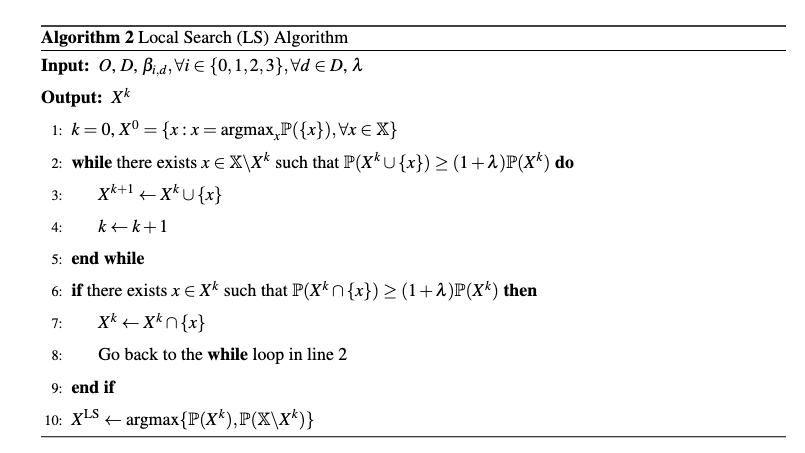


\begin{equation}
\begin{aligned}
\max  \mathbb{P}(X) &=   \sum_{o\in O} \mathbb{P}_{o}(X)=  \sum_{o\in O} \left(1- \prod_{d \in D_{o}(X)}\frac{u_{d}^{\textrm{c}}+\sum_{o^{'} \in  O_{d}(X)/\{o\}} u_{d,o}}{u_{d}^{\textrm{c}}+\sum_{o^{'}  \in  O_{d}(X)} u_{d,o}}\right).
\label{eq:objective_simplified_2}
\end{aligned}
\end{equation}

In [83]:
class Joint_Optimization(object):
    
    def __init__(self,utility,decline,lambda_=.001):
        
        self.utility=utility
        
        self.decline=decline
        
        self.lambda_=lambda_

    def get_obj(self,x):

        p=0

        for o in range(x.shape[0]):

            p+=self.get_prob(o,x)

        return p

    def get_prob(self,o,x):

        p=1

        drivers=x[o,:]

        for d in np.nonzero(drivers)[0]:

            menus=np.nonzero(np.array(x[:,d]))
            
            p*=1-((self.utility[o,d])/(self.utility[menus,d].sum()+self.decline[d]))

        return 1-p
    
    def get_gradient(self,x,o,d):
        
        copy_x=copy.deepcopy(x)

        copy_x[o,d]=0
        
        gradient=self.get_obj(copy_x)-self.get_obj(x)
        
        return gradient

    
    def local_search(self):
        
        # 01 initialization
        
        x = np.zeros([self.utility.shape[0],self.utility.shape[1]])
        
        search={}
        
        for o in range(x.shape[0]):
        
            for d in range(x.shape[1]):
                
                search[(o,d)]=self.get_gradient(x,o,d)
                
        best_x=max(search, key=search.get)
            
        o,d=best_x[0],best_x[1]
        
        x[o][d]=1
        
        # 02 while loop
        
        x=self.exists(x)
        
        # 03 check
        
        redo=False
        
        x,redo = self.check(x)
        
        while redo:
            
            x = self.exists(x)
            
            x,redo = self.check(x)
 
        return x
    

    def exists(self,x):

        i=0
        
        excludes=[e for e in np.argwhere(x == 0)]
        
        while i<=len(excludes)-1:

            pair=excludes[i]

            o,d=pair[0],pair[1]

            copy_x=copy.deepcopy(x)

            copy_x[o,d]=1

            if self.get_obj(copy_x)/self.get_obj(x)>=1+self.lambda_:

                x[o][d]=1
                
                excludes=[e for e in np.argwhere(x == 0)]
        
                i=0

            else:

                i+=1
        
        return x
        
    def check(self,x):
        
        includes=[e for e in np.argwhere(x == 1)]
        
        redo=False
        
        i=0
        
        while i<=len(includes)-1:

            pair=includes[i]

            o,d=pair[0],pair[1]

            copy_x=copy.deepcopy(x)

            copy_x[o,d]=0
            
            if self.get_obj(copy_x)/self.get_obj(x)>=1+self.lambda_:
                
                x[o,d]=0

                redo=True
                
                break
                
            else:
                
                i+=1
                
        return x,redo

        
    



### Instance generation

\begin{equation}
u_{d,o}=\overbrace{\beta_{0,d}}^{\textrm{constant}}+\overbrace{\beta_{1,d} \cdot I_{o}}^{\textrm{order type}} +\overbrace{\beta_{2,d} \cdot f_{o}}^{\textrm{order fare}} - \overbrace{\beta_{3,d} \cdot \tau(l_{d},l^{\textrm{org}}_{o})}^{\textrm{pickup time}}  + \overbrace{\beta_{4,d} \cdot V(l^{\textrm{dest}}_{o})}^{\textrm{value of the order's destination}}
\label{eq:utility}
\end{equation}

In [119]:
# 00 preference parameters

beta_1 = 1

beta_2 = 1.5

beta_3 = 1

beta_4 = 6.5

# 01 numbers of orders and drivers

first_instances=[(10,5),(10,10),(10,15),(10,20),(10,25),(10,30),(10,35),(10,40),(10,45),(10,50)]

for pair in first_instances:
    
    order_num,driver_num=pair[0],pair[1]

    # 02 type

    type_array=np.ones([order_num,driver_num])

    # 03 order fare

    fare_array=np.array([Truncated_Gauss(6.5,3,4,25) for i in range(order_num)])

    fare_array=np.repeat(fare_array, repeats=driver_num, axis=0).reshape(order_num,driver_num)

    # 04 pickup time

    pickup_array=np.random.rand(order_num,driver_num)*3

    # 05 value of destination

    spatial_array=np.random.rand(order_num,driver_num)

    # 06 utilities

    utility = beta_1*type_array+beta_2*fare_array-beta_3*pickup_array+beta_4*spatial_array

    # 07 declines utilities

    decline = np.array([Truncated_Gauss(20,5,15,25) for i in range(driver_num)])

    # 08 save

    np.save("./instances/utility_"+str(order_num)+"_"+str(driver_num),utility)

    np.save("./instances/decline"+str(order_num)+"_"+str(driver_num),decline)


### test

In [120]:
first_instances=[(10,5),(10,10),(10,15),(10,20),(10,25),(10,30),(10,35),(10,40),(10,45),(10,50)]

lambdas=[0.001,0.002,0.005,0.01,0.02,0.05,0.1]

performance_record={}

time_record={}

for pair in first_instances:
    
    performance_record[pair]={}

    time_record[pair]={}
    
    order_num,driver_num=pair[0],pair[1]
    
    utility=np.load("./instances/utility_"+str(order_num)+"_"+str(driver_num)+".npy")
    
    decline=np.load("./instances/decline"+str(order_num)+"_"+str(driver_num)+".npy")
    
    for lambda_ in lambdas:
        
        joint_opt=Joint_Optimization(utility,decline,lambda_=lambda_)
        
        x=joint_opt.local_search()
        
        obj=joint_opt.get_obj(x)
        
        performance_record[pair][lambda_]=obj
        
        print(pair,lambda_,obj)
        
        if obj>order_num:
            
            break

performance_record

(10, 5) 0.001 3.646864222303093
(10, 5) 0.002 3.646864222303093
(10, 5) 0.005 3.63305231203995
(10, 5) 0.01 3.5419998514840962
(10, 5) 0.02 3.38514076928435
(10, 5) 0.05 2.8631542136373924
(10, 5) 0.1 2.3876317721847853
(10, 10) 0.001 5.914180104884182
(10, 10) 0.002 5.9137050750705615
(10, 10) 0.005 5.821475090231486
(10, 10) 0.01 5.647930808314516
(10, 10) 0.02 5.333469377821516
(10, 10) 0.05 4.723705479720326
(10, 10) 0.1 3.73389755635589
(10, 15) 0.001 7.394667742763985
(10, 15) 0.002 7.366681409663004
(10, 15) 0.005 7.293998085642686
(10, 15) 0.01 6.985912546990872
(10, 15) 0.02 6.673982469643222
(10, 15) 0.05 6.210428645618218
(10, 15) 0.1 4.560006095260308
(10, 20) 0.001 8.360329243515904
(10, 20) 0.002 8.320895091181706
(10, 20) 0.005 8.190026555249409
(10, 20) 0.01 7.926029050444621
(10, 20) 0.02 7.782739768764266
(10, 20) 0.05 6.542552887070306
(10, 20) 0.1 5.620285788609269
(10, 25) 0.001 8.914847002681134
(10, 25) 0.002 8.846738957684765
(10, 25) 0.005 8.637242973761182
(10

{(10, 5): {0.001: 3.646864222303093,
  0.002: 3.646864222303093,
  0.005: 3.63305231203995,
  0.01: 3.5419998514840962,
  0.02: 3.38514076928435,
  0.05: 2.8631542136373924,
  0.1: 2.3876317721847853},
 (10, 10): {0.001: 5.914180104884182,
  0.002: 5.9137050750705615,
  0.005: 5.821475090231486,
  0.01: 5.647930808314516,
  0.02: 5.333469377821516,
  0.05: 4.723705479720326,
  0.1: 3.73389755635589},
 (10, 15): {0.001: 7.394667742763985,
  0.002: 7.366681409663004,
  0.005: 7.293998085642686,
  0.01: 6.985912546990872,
  0.02: 6.673982469643222,
  0.05: 6.210428645618218,
  0.1: 4.560006095260308},
 (10, 20): {0.001: 8.360329243515904,
  0.002: 8.320895091181706,
  0.005: 8.190026555249409,
  0.01: 7.926029050444621,
  0.02: 7.782739768764266,
  0.05: 6.542552887070306,
  0.1: 5.620285788609269},
 (10, 25): {0.001: 8.914847002681134,
  0.002: 8.846738957684765,
  0.005: 8.637242973761182,
  0.01: 8.41475136006306,
  0.02: 7.861434415531637,
  0.05: 6.489375089235128,
  0.1: 5.466823673

### plot

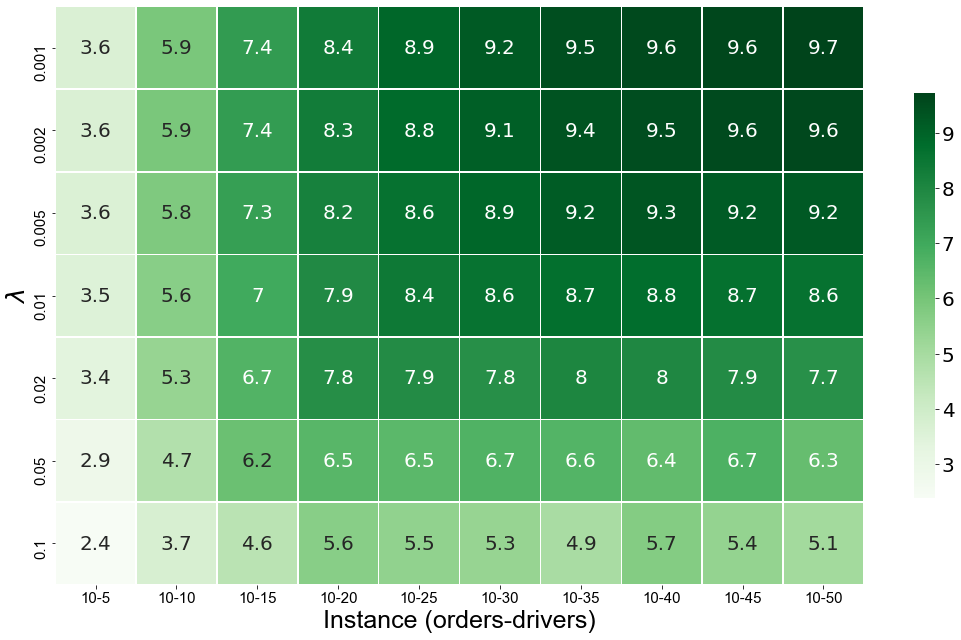

In [123]:
Figure_path = './figures/'

df=pd.DataFrame(performance_record)


font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

fig, axs = plt.subplots(figsize=(15, 9))

sns.heatmap(df, annot=True, linewidths=.5,ax=axs, cmap="Greens",cbar_kws={"shrink": 0.7},annot_kws={"size":20})

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]

axs.set_ylabel('$\lambda$',font_label)

axs.set_xlabel('Instance (orders-drivers)',font_label)

cbar = axs.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)


current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join(Figure_path,'parameter_tuning.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.tight_layout()

plt.show()
